In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
from sklearn.pipeline import make_pipeline
import warnings
from sklearn import preprocessing
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/WiDS/train_data.csv')
df.shape

(375734, 246)

## Exploratory Data Analysis & Preprocessing

### Drop missing values

In [ ]:
# missing values
missing = pd.DataFrame(df.isna().sum() / df.shape[0], columns=['percent'])
print(missing[missing.percent>0])

                          percent
nmme0-tmp2m-34w__ccsm30  0.042408
nmme-tmp2m-56w__ccsm3    0.027360
nmme-prate-34w__ccsm3    0.023256
nmme0-prate-56w__ccsm30  0.042408
nmme0-prate-34w__ccsm30  0.042408
nmme-prate-56w__ccsm3    0.027360
nmme-tmp2m-34w__ccsm3    0.023256
ccsm30                   0.042408


In [ ]:
df1 = df.dropna(how='any')
print(df1.shape)
print(df1.shape[0]/df.shape[0])

(352604, 246)
0.9384404924760602


In [ ]:
X = df1.drop(['index','contest-tmp2m-14d__tmp2m'], axis = 1)
y = df1['contest-tmp2m-14d__tmp2m'].to_numpy()
y = y.reshape(y.shape[0],1)
print(X.shape, y.shape)

(352604, 244) (352604, 1)


### Drop highly correlated columns

In [ ]:
corr_mat = X.corr()

# highly correlated columns
def get_redundant_pairs(df):
    cols = list(df.columns)
    pairs_to_drop = set()
    for i in range(df.shape[0]):
        for j in range(i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df,n=5):
    # here df is a correlation matrix
    top_corr = df.abs().unstack()
    pairs_to_drop = get_redundant_pairs(df)
    top_corr = top_corr.drop(pairs_to_drop).sort_values(ascending=False)
    return top_corr[0:n]

In [ ]:
top_related_vars = get_top_abs_correlations(corr_mat,n=500)
print(top_related_vars)

nmme-tmp2m-56w__nmmemean     nmme-tmp2m-34w__nmmemean       0.998910
nmme0-tmp2m-34w__gfdlflora0  nmme0-tmp2m-34w__gfdlflorb0    0.998893
gfdlflora0                   gfdlflorb0                     0.998837
nmme-tmp2m-56w__cfsv2        nmme-tmp2m-34w__cfsv2          0.998234
nmme-tmp2m-56w__gfdlflorb    nmme-tmp2m-34w__gfdlflorb      0.998043
                                                              ...   
nmme0-tmp2m-34w__nmme0mean   nmme-tmp2m-56w__gfdlflorb      0.899157
                             nmme-tmp2m-56w__ccsm3          0.898802
nmme0-tmp2m-34w__nasa0       gfdlflorb0                     0.898714
                             nmme-tmp2m-56w__cfsv2          0.898698
nmme0-tmp2m-34w__nmme0mean   nmme-tmp2m-34w__ccsm4          0.898526
Length: 500, dtype: float64


In [ ]:
# drop highly correlated columns (corr > 0.95)
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool_))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)] # change boundary here
X_dropcorr = X.drop(to_drop, axis=1)
print(X_dropcorr.shape)

(352604, 189)


In [ ]:
# check correlation again
corr_mat2 = X_dropcorr.corr()
print()
print(get_top_abs_correlations(corr_mat2,n=10))


nmme0-tmp2m-34w__cancm30          cancm30                       0.941017
mei__mei                          mei__meirank                  0.932333
nmme-prate-34w__gfdlflora         nmme-prate-34w__gfdlflorb     0.927319
nmme0-prate-56w__nmme0mean        nmme0-prate-34w__nmme0mean    0.922748
nmme0-tmp2m-34w__cancm30          nmme-tmp2m-56w__cancm3        0.917391
contest-pres-sfc-gauss-14d__pres  elevation__elevation          0.916116
sst-2010-1                        icec-2010-1                   0.915411
nmme0-prate-56w__cfsv20           nmme0-prate-34w__cfsv20       0.909769
nmme-prate-34w__gfdlflorb         nmme-prate-34w__nmmemean      0.907972
nmme-prate-34w__gfdl              nmme-prate-34w__nmmemean      0.907903
dtype: float64


### Dev and Test Split and Preprocessing

In [ ]:
# set random_state = 0
X_dev, X_test, y_dev, y_test = train_test_split(X_dropcorr, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=0)

In [ ]:
# check for string type columns
stridx = (X_dropcorr.applymap(type) == str).all(0)
print(X_dropcorr.columns[stridx])

Index(['startdate', 'climateregions__climateregion'], dtype='object')


In [ ]:
X_dropcorr['climateregions__climateregion'].value_counts()

BSk    131026
Dfb     49392
Cfa     48706
Csb     38416
Dfa     21266
BWk     13034
Dfc     11662
BWh      8918
Csa      8918
Dsb      7546
BSh      4802
Cfb      4116
Dsc      2744
Dwa      1372
Dwb       686
Name: climateregions__climateregion, dtype: int64

In [ ]:
# Combine numerical and categorical variables
# Apply standardized scaling to numerical variables
# One Hot Encoding to climateregions
# Ordinal Encoding to startdate

ohe_features = ['climateregions__climateregion']
ord_features = ['startdate']
num_features = [column for column in X_dropcorr.columns if column not in ohe_features and column not in ord_features]

X_train_mixed = X_train[ohe_features + ord_features + num_features]
X_val_mixed = X_val[ohe_features + ord_features + num_features]
X_test_mixed = X_test[ohe_features + ord_features + num_features]

preprocess = make_column_transformer((StandardScaler(), num_features),
                                     (OneHotEncoder(), ohe_features),
                                     (OrdinalEncoder(), ord_features))
preprocess.fit(X_train_mixed)
X_train_prepro = preprocess.transform(X_train_mixed)
X_val_prepro = preprocess.transform(X_val_mixed)
X_test_prepro = preprocess.transform(X_test_mixed)

print(preprocess.named_transformers_['onehotencoder'].get_feature_names())

['x0_BSh' 'x0_BSk' 'x0_BWh' 'x0_BWk' 'x0_Cfa' 'x0_Cfb' 'x0_Csa' 'x0_Csb'
 'x0_Dfa' 'x0_Dfb' 'x0_Dfc' 'x0_Dsb' 'x0_Dsc' 'x0_Dwa' 'x0_Dwb']


In [ ]:
# Add column for bias term
X_train_stacked = np.hstack([np.ones((X_train_prepro.shape[0], 1)), X_train_prepro])
X_val_stacked = np.hstack([np.ones((X_val_prepro.shape[0], 1)), X_val_prepro])
X_test_stacked = np.hstack([np.ones((X_test_prepro.shape[0], 1)), X_test_prepro])

print(X_train_stacked.shape)
print(X_val_stacked.shape)
print(X_test_stacked.shape)

(211562, 204)
(70521, 204)
(70521, 204)


## Machine Learning Models

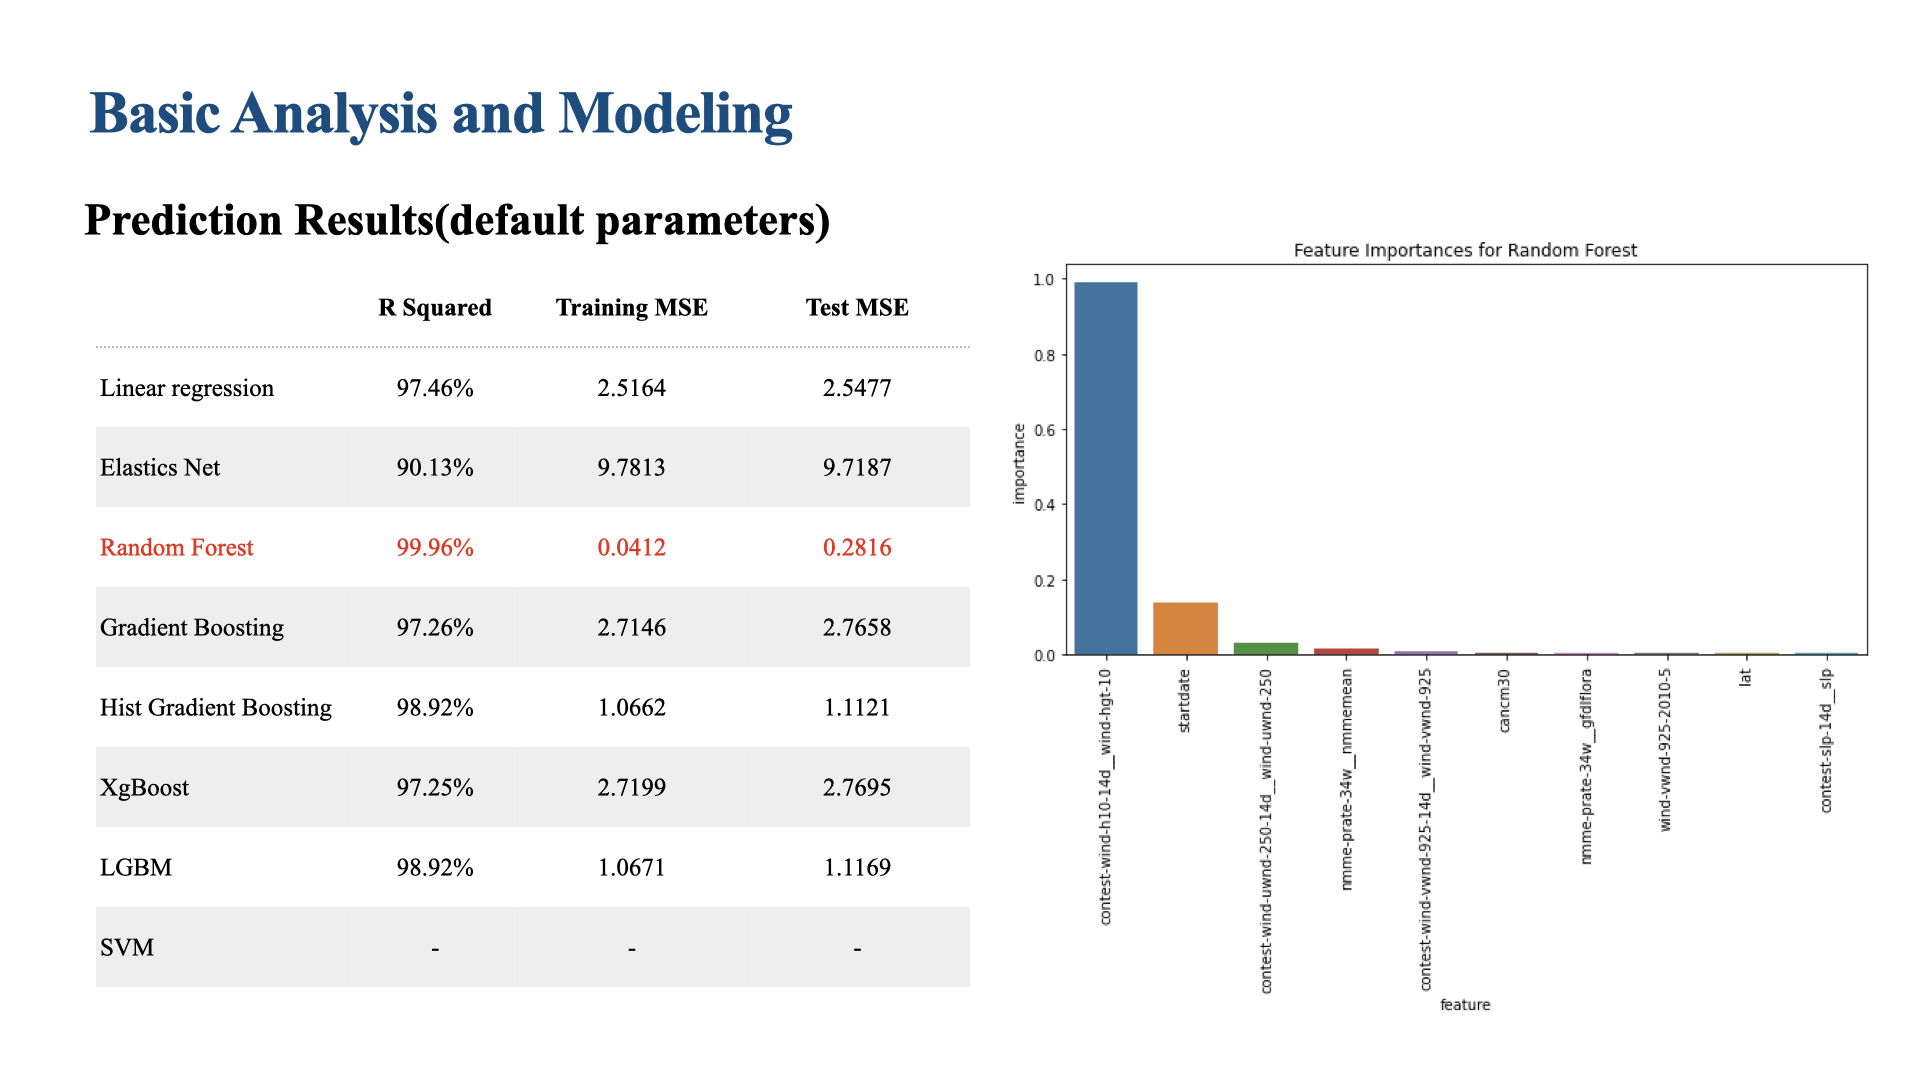

### Random Forest

In [ ]:
rg_rf = RandomForestRegressor(random_state = 0) # 5-fold cv by default
rg_rf.fit(X_train_stacked, y_train)
rf_train_pre = rg_rf.predict(X_train_stacked)
rf_val_pre = rg_rf.predict(X_val_stacked)
rf_test_pre = rg_rf.predict(X_test_stacked)
print(f'Training R squared: ',rg_rf.score(X_train_stacked, y_train))
print(f'Training MSE: ', mean_squared_error(y_train, rf_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, rf_val_pre))
print(f'Test score: ', mean_squared_error(y_test, rf_test_pre))


Training R squared:  0.9995841962734838
Training MSE:  0.04119512965828963
Validation score:  0.28851471581288446
Test score:  0.28162926987715065


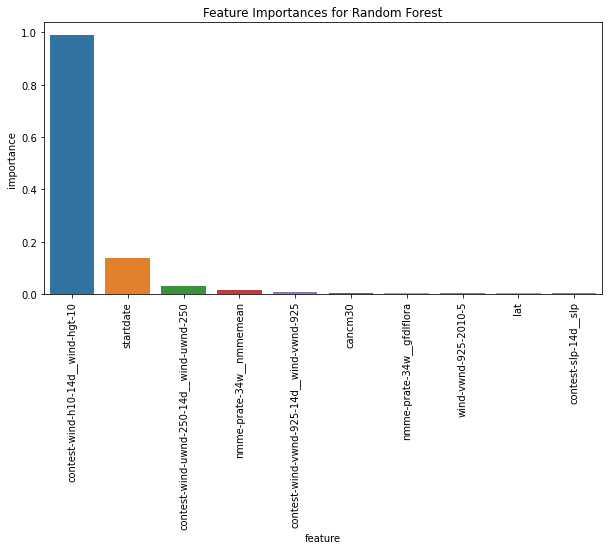

In [ ]:
imp_rf = rg_rf.feature_importances_[1:]
imp_rf = preprocessing.normalize([imp_rf])[0]
feature_importance_rf = zip(X_test, imp_rf)
df_rf = pd.DataFrame(data=feature_importance_rf, columns=['feature', 'importance'])
df_rf = df_rf.sort_values(by='importance', ascending=False)
df_rf = df_rf.iloc[:10,:]
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.barplot(data=df_rf, x='feature', y='importance').set(title='Feature Importances for Random Forest')
plt.xticks(rotation=90)
plt.show()

In [ ]:
params = {'n_estimators': [20, 50, 100, 150, 200],
          #'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
        #'max_features': ['sqrt', 'log2', 'None'],
          'max_depth': [5, 10, 15, 20],
          'min_samples_split': [2, 5, 10, 15]
          #'min_samples_leaf': [1, 2, 4],
          }

rg_rf = RandomForestRegressor(random_state = 0) # 5-fold cv by default
pipe_rf = make_pipeline(RandomizedSearchCV(rg_rf, 
                                    param_distributions = params,
                                    cv = 3,
                                    n_jobs = -1,
                                    random_state = 0,
                                    return_train_score = True))
pipe_rf.fit(X_train_stacked, y_train)
grid_results_rf = pipe_rf.named_steps['randomizedsearchcv']

print(f'Best train score: ', grid_results_rf.best_score_ )
print(f'Validation score: ', pipe_rf.score(X_val_stacked, y_val))
print(f'Test score:       ', pipe_rf.score(X_test_stacked, y_test))
print(f'Best model params: ', grid_results_rf.best_params_)

### Gradient Boosting

In [ ]:
params = {'loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
          'learning_rate': [0.01,0.02,0.05,0.1],
          'n_estimators': [30, 50, 100, 200, 300],
          'criterion':['friedman_mse', 'squared_error'],
          'max_features': ['sqrt', 'log2', 'auto'],
          'max_depth': [2, 5, 10, 15, 20],
          'min_samples_split': [2, 5, 10, 15],
          'min_samples_leaf': [1, 2, 4],
               }

rg_gb = GradientBoostingRegressor(random_state = 0, warm_start = True) 
pipe_gb = make_pipeline(RandomizedSearchCV(rg_gb, 
                                    param_distributions = params,
                                    n_jobs = -1,
                                    cv = 3,
                                    return_train_score = True))
pipe_gb.fit(X_train_stacked, y_train)
random_results_gb = pipe_rf.named_steps['randomizedsearchcv']

print(f'Best train score: ', random_results_gb.best_score_ )
print(f'Validation score: ', pipe_gb.score(X_val_stacked, y_val))
print(f'Test score:       ', pipe_gb.score(X_test_stacked, y_test))
print(f'Best model params: ', random_results_gb.best_params_)

KeyboardInterrupt: ignored

In [ ]:

rg_gb = GradientBoostingRegressor(random_state = 0, warm_start = True)  # 5-fold cv by default
rg_gb.fit(X_train_stacked, y_train)
gb_train_pre = rg_gb.predict(X_train_stacked)
gb_val_pre = rg_gb.predict(X_val_stacked)
gb_test_pre = rg_gb.predict(X_test_stacked)
print(f'Training R squared: ',rg_gb.score(X_train_stacked, y_train))
print(f'Training MSE: ', mean_squared_error(y_train, gb_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, gb_val_pre))
print(f'Test score: ', mean_squared_error(y_test, gb_test_pre))


Training R squared:  0.972600573980122
Training MSE:  2.714556978381523
Validation score:  2.7878411073262677
Test score:  2.765794687459479


### Hist Gradient Boosting

In [ ]:
params = {'loss':['squared_error', 'absolute_error', 'poisson', 'quantile'],
          'learning_rate': [0.01,0.02,0.05,0.1],
          'max_iter': [30, 50, 100, 200, 300],
          'criterion':['friedman_mse', 'squared_error'],
          'max_features': ['sqrt', 'log2', 'auto'],
          'max_depth': [2, 5, 10, 15, 20],
          'early_stopping': ['auto', True]
          }

rg_histgb = HistGradientBoostingRegressor(random_state = 0, warm_start = True) 
pipe_histgb = make_pipeline(GridSearchCV(rg_histgb, 
                                    param_grid = params,
                                    n_jobs = -1,
                                    return_train_score = True))
pipe_histgb.fit(X_train_stacked, y_train)
grid_results_histgb = pipe_histgb.named_steps['gridsearchcv']

print(f'Best train score: ', grid_results_histgb.best_score_ )
print(f'Validation score: ', pipe_histgb.score(X_val_stacked, y_val))
print(f'Test score:       ', pipe_histgb.score(X_test_stacked, y_test))
print(f'Best model params: ', grid_results_histgb.best_params_)

In [ ]:
rg_hist = HistGradientBoostingRegressor(random_state = 0, warm_start = True)  # 5-fold cv by default
rg_hist.fit(X_train_stacked, y_train)
hist_train_pre = rg_hist.predict(X_train_stacked)
hist_val_pre = rg_hist.predict(X_val_stacked)
hist_test_pre = rg_hist.predict(X_test_stacked)
print(f'Training R squared: ',rg_hist.score(X_train_stacked, y_train))
print(f'Training MSE: ', mean_squared_error(y_train, hist_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, hist_val_pre))
print(f'Test score: ', mean_squared_error(y_test, hist_test_pre))

Training R squared:  0.9892382927191664
Training MSE:  1.0661999845285846
Validation score:  1.1158420644965972
Test score:  1.1121204618763532


### XgBoost

In [ ]:
params = {'max_depth':[3,4,6,8,10,12,20],
          'n_estimators': [50, 100, 150, 200, 300],
          'learning_rate': [0.001,0.01,0.02,0.05,0.1]
          }

rg_xgb = XGBRegressor(random_state = 0) 
pipe_xgb = make_pipeline(GridSearchCV(rg_xgb, 
                                    param_grid = params,
                                    n_jobs = -1,
                                    return_train_score = True))
pipe_xgb.fit(X_train_stacked, y_train)
grid_results_xgb = pipe_xgb.named_steps['gridsearchcv']

print(f'Best train score: ', grid_results_xgb.best_score_ )
print(f'Validation score: ', pipe_xgb.score(X_val_stacked, y_val))
print(f'Test score:       ', pipe_xgb.score(X_test_stacked, y_test))
print(f'Best model params: ', grid_results_xgb.best_params_)

In [ ]:
rg_xgb = XGBRegressor(random_state = 0)  # 5-fold cv by default
rg_xgb.fit(X_train_stacked, y_train)
xgb_train_pre = rg_xgb.predict(X_train_stacked)
xgb_val_pre = rg_xgb.predict(X_val_stacked)
xgb_test_pre = rg_xgb.predict(X_test_stacked)
print(f'Training R squared: ',rg_xgb.score(X_train_stacked, y_train))
print(f'Training MSE: ', mean_squared_error(y_train, xgb_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, xgb_val_pre))
print(f'Test score: ', mean_squared_error(y_test, _test_pre))

[01:47:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training R squared:  0.972547094310702
Training MSE:  2.719855396301678
Validation score:  2.7898916066384913
Test score:  2.7694919845860366


### LGBM

In [ ]:
params = {'boosting_type':['gbdt', 'rf', 'dart'],
         'max_depth':[3,4,6,8,10,12,20],
         'n_estimators':[50, 100, 150, 200, 300],
         'learning_rate':[0.001,0.01,0.05,0.1,1]
}
rg_lgbm = LGBMRegressor(random_state = 0) 
pipe_lgbm = make_pipeline(GridSearchCV(rg_lgbm, 
                                    param_grid = params,
                                    n_jobs = -1,
                                    return_train_score = True))
pipe_lgbm.fit(X_train_stacked, y_train)
grid_results_lgbm = pipe_lgbm.named_steps['gridsearchcv']

print(f'Best train score: ', grid_results_lgbm.best_score_ )
print(f'Validation score: ', pipe_lgbm.score(X_val_stacked, y_val))
print(f'Test score:       ', pipe_lgbm.score(X_test_stacked, y_test))
print(f'Best model params: ', grid_results_lgbm.best_params_)

In [ ]:
rg_lgbm = LGBMRegressor(random_state = 0)  # 5-fold cv by default
rg_lgbm.fit(X_train_stacked, y_train)
lgbm_train_pre = rg_lgbm.predict(X_train_stacked)
lgbm_val_pre = rg_lgbm.predict(X_val_stacked)
lgbm_test_pre = rg_lgbm.predict(X_test_stacked)
print(f'Training R squared: ',rg_lgbm.score(X_train_stacked, y_train))
print(f'Training MSE: ', mean_squared_error(y_train, lgbm_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, lgbm_val_pre))
print(f'Test score: ', mean_squared_error(y_test, lgbm_test_pre))

Training R squared:  0.9892297015514637
Training MSE:  1.0670511415646102
Validation score:  1.1158724445579844
Test score:  1.1169247540684926


### SVM

In [ ]:
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
          'C':[0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
}
rg_svm = SVR() 
pipe_svm = make_pipeline(GridSearchCV(rg_svm, 
                                    param_grid = params,
                                    n_jobs = -1,
                                    return_train_score = True))
pipe_svm.fit(X_train_stacked, y_train)
grid_results_svm = pipe_lgbm.named_steps['gridsearchcv']

print(f'Best train score: ', grid_results_svm.best_score_ )
print(f'Validation score: ', pipe_svm.score(X_val_stacked, y_val))
print(f'Test score:       ', pipe_svm.score(X_test_stacked, y_test))
print(f'Best model params: ', grid_results_svm.best_params_)

In [ ]:
rg_svm = SVR()  # 5-fold cv by default
rg_svm.fit(X_train_stacked, y_train)
svm_train_pre = rg_svm.predict(X_train_stacked)
svm_val_pre = rg_svm.predict(X_val_stacked)
svm_test_pre = rg_svm.predict(X_test_stacked)
print(f'Training R squared: ',rg_svm.score(X_train_stacked, y_train))
print(f'Training MSE: ', mean_squared_error(y_train, svm_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, svm_val_pre))
print(f'Test score: ', mean_squared_error(y_test, svm_test_pre))

### Linear Regression

In [ ]:
rg_lm = LinearRegression() 
rg_lm.fit(X_train_stacked, y_train)
lm_train_pre = rg_lm.predict(X_train_stacked)
lm_val_pre = rg_lm.predict(X_val_stacked)
lm_test_pre = rg_lm.predict(X_test_stacked)
print(f'Training R squared: ',rg_lm.score(X_train_stacked, y_train))
print(f'Training MSE: ', mean_squared_error(y_train, lm_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, lm_val_pre))
print(f'Test score: ', mean_squared_error(y_test, lm_test_pre))

Training R squared:  0.9746007865927272
Training MSE:  2.5163889181508026
Validation score:  2.5410875186744626
Test score:  2.547671110164228


### Elastic Net

In [ ]:
params = {'l1_ratio': [0,0.5,1]}
rg_elastic = ElasticNet(random_state=0, warm_start=True) 
pipe_elastic = make_pipeline(GridSearchCV(rg_elastic, 
                                    param_grid = params,
                                    n_jobs = -1,
                                    return_train_score = True))
pipe_elastic.fit(X_train_stacked, y_train)
grid_results_elastic = pipe_elastic.named_steps['gridsearchcv']

print(f'Best train score: ', grid_results_elastic.best_score_ )
print(f'Validation score: ', pipe_elastic.score(X_val_stacked, y_val))
print(f'Test score:       ', pipe_elastic.score(X_test_stacked, y_test))
print(f'Best model params: ', grid_results_elastic.best_params_)

In [ ]:
rg_elastic = ElasticNet(random_state=0, warm_start=True) 
rg_elastic.fit(X_train_stacked, y_train)
elastic_train_pre = rg_elastic.predict(X_train_stacked)
elastic_val_pre = rg_elastic.predict(X_val_stacked)
elastic_test_pre = rg_elastic.predict(X_test_stacked)
print(f'Training R squared: ',rg_elastic.score(X_train_stacked, y_train))
print(f'Training MSE: ', mean_squared_error(y_train, elastic_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, elastic_val_pre))
print(f'Test score: ', mean_squared_error(y_test, elastic_test_pre))

Training R squared:  0.9012720054844169
Training MSE:  9.781327765021626
Validation score:  9.886450523970247
Test score:  9.718715332623836


In [ ]:
!pip install pytorch_tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 2.3 MB/s eta 0:00:00


In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor

regressor = TabNetRegressor()
regressor.fit(X_train=X_train_stacked, y_train=y_train,
          #patience=TabNet_params['patience'], max_epochs=epochs,
          eval_metric=['rmse'])

epoch 0  | loss: 22.9357 |  0:00:30s
epoch 1  | loss: 3.7343  |  0:00:56s
epoch 2  | loss: 2.84019 |  0:01:22s
epoch 3  | loss: 2.45366 |  0:01:48s
epoch 4  | loss: 2.24678 |  0:02:18s
epoch 5  | loss: 2.09828 |  0:02:47s
epoch 6  | loss: 2.08619 |  0:03:15s
epoch 7  | loss: 1.91305 |  0:03:42s
epoch 8  | loss: 1.79972 |  0:04:08s
epoch 9  | loss: 1.78713 |  0:04:35s
epoch 10 | loss: 1.67231 |  0:05:01s
epoch 11 | loss: 1.61328 |  0:05:28s
epoch 12 | loss: 1.611   |  0:05:55s
epoch 13 | loss: 1.56678 |  0:06:24s
epoch 14 | loss: 1.51395 |  0:06:51s
epoch 15 | loss: 1.45496 |  0:07:15s
epoch 16 | loss: 1.52519 |  0:07:43s
epoch 17 | loss: 1.3627  |  0:08:08s
epoch 18 | loss: 1.41785 |  0:08:35s
epoch 19 | loss: 1.31133 |  0:08:59s
epoch 20 | loss: 1.29229 |  0:09:27s
epoch 21 | loss: 1.25605 |  0:09:52s
epoch 22 | loss: 1.29648 |  0:10:18s
epoch 23 | loss: 1.2467  |  0:10:42s
epoch 24 | loss: 1.24462 |  0:11:09s
epoch 25 | loss: 1.20316 |  0:11:33s
epoch 26 | loss: 1.21534 |  0:12:00s
e

In [ ]:
tabnet_train_pre = regressor.predict(X_train_stacked)
tabnet_val_pre = regressor.predict(X_val_stacked)
tabnet_test_pre = regressor.predict(X_test_stacked)


In [ ]:
print(f'Training MSE: ', mean_squared_error(y_train, tabnet_train_pre))
print(f'Validation score: ', mean_squared_error(y_val, tabnet_val_pre))
print(f'Test score: ', mean_squared_error(y_test, tabnet_test_pre))

Training MSE:  0.6909353750859624
Validation score:  0.7182499347879969
Test score:  0.7171123563870262
